<a href="https://colab.research.google.com/github/Andrian0s/ML4NLP1-2025-Tutorial-Notebooks/blob/main/tutorials_notebooks_in_class_2024/W02_Intro_to_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to scikit-learn

We would like to introduce you to scikit-learn with the help of an instructional example about text classification. We will cover the most basic principles and ideas about scikit-learn in this notebook. This tutorial is inspired by the sklearn tutorial on http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html, but contains a few more explanations and is suited to introduce scikit-learn in class.

$Author$: Phillip Ströbel

With minor adjustments from: Janis Goldzycher, Andrianos Michail, Michelle Wastl

## Data

Get the data from http://qwone.com/~jason/20Newsgroups/. We will work with the 20news-bydate.tar.gz data set. Unzip it to a suitable destination. Here, all the data lies in the data folder. To our convenience, it has already been split into a training and a test set, so we don't have to care about this. What we need to do though is get the data and put it into a dataframe (you could also only work with dictionaries or other data containers). We do this for both the training and the test set.

In [ ]:
!wget http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz

--2025-09-21 18:15:25--  http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz
Resolving qwone.com (qwone.com)... 173.48.205.131
Connecting to qwone.com (qwone.com)|173.48.205.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14464277 (14M) [application/x-gzip]
Saving to: ‘20news-bydate.tar.gz’

20news-bydate.tar.g 100%[===================>]  13.79M  8.82MB/s    in 1.6s    

2025-09-21 18:15:27 (8.82 MB/s) - ‘20news-bydate.tar.gz’ saved [14464277/14464277]



In [ ]:
!tar -xvzf 20news-bydate.tar.gz
!echo "The files are unzipped and this folder now contains:"
!ls

In [ ]:
!mkdir data
!mv 20news-bydate-* data/

In [ ]:
import os
import pandas as pd


def create_df(path_to_data, random_state=42):
    """
    Takes the path of a folder containing all the subfolders (which contain the actual documents).
    Builds a pandas datafram with document ids, the text and the label.
    :param path_to_data: path to top folder as a string
    :param random_state: integer, seed for shuffling
    :return: pandas dataframe with all the data
    """
    doc_list = list()  # doc_list now: [[doc<str>, label<str>], ...]

    for category in os.listdir(path_to_data):
        for document in os.listdir(os.path.join(path_to_data, category)):
            doc = open(os.path.join(path_to_data, category, document), 'r', encoding='latin-1').read().replace('\n', ' ')
            doc_list.append([doc, category])

    df = pd.DataFrame(doc_list, columns=['text', 'label'])

    return df.sample(frac=1, random_state=random_state) # return and shuffle dataframe

In [ ]:
train = create_df('data/20news-bydate-train')
test = create_df('data/20news-bydate-test')

Several ways to inspect the data.

In [ ]:
print('training size: ', train.shape)
print('test size: ', test.shape)

training size:  (11314, 2)
test size:  (7532, 2)


In [ ]:
train.tail(10)

,text,label
7492,From: kevin@rotag.mi.org (Kevin Darcy) Subject...,talk.politics.misc
3546,From: tecot@Xenon.Stanford.EDU (Edward M. Teco...,comp.sys.mac.hardware
5582,From: sandvik@newton.apple.com (Kent Sandvik) ...,talk.religion.misc
4793,From: dchhabra@stpl.ists.ca (Deepak Chhabra) S...,rec.sport.hockey
3813,From: HK.MLR@forsythe.stanford.edu (Mark Rogow...,comp.sys.mac.hardware


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11314 entries, 7492 to 7270
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   label   11314 non-null  object
dtypes: object(2)
memory usage: 265.2+ KB


In [ ]:
train.describe()

,text,label
count,11314,11314
unique,11314,20
top,From: yoshi@atlantis.CS.ORST.EDU (Digital Exod...,rec.sport.hockey
freq,1,600


In [ ]:
train.groupby('label').size()

,0
label,
alt.atheism,480
comp.graphics,584
comp.os.ms-windows.misc,591
comp.sys.ibm.pc.hardware,590
comp.sys.mac.hardware,578
comp.windows.x,593
misc.forsale,585
rec.autos,594
rec.motorcycles,598


As usual, we split the labels from the training and the test set.

In [ ]:
X_train = train.text
y_train = train.label
X_test = test.text
y_test = test.label

In [ ]:
type(X_train)

pandas.core.series.Series

Series is just a "One-dimensional ndarray with axis labels". Let's see if we got this right.

In [ ]:
print('Training set shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test set shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training set shape:  (11314,)
Training labels shape:  (11314,)
Test set shape:  (7532,)
Test labels shape:  (7532,)


In [ ]:
X_train.head()

,text
7492,From: kevin@rotag.mi.org (Kevin Darcy) Subject...
3546,From: tecot@Xenon.Stanford.EDU (Edward M. Teco...
5582,From: sandvik@newton.apple.com (Kent Sandvik) ...
4793,From: dchhabra@stpl.ists.ca (Deepak Chhabra) S...
3813,From: HK.MLR@forsythe.stanford.edu (Mark Rogow...


## Preprocessing
So far, so good! But we know that machine learning algorithms cannot work with text data directly. So we need to vectorise the data somehow. also, we might do some preprocessing. Let's see how we can tackle these problems.
### Vectorise the data
Luckily, sklearn offers some nice classes which help us. We should tokenise the data and then vectorise it. Conveniently, sklearns `CountVectoriser()` does exactly that. Let's see how it works.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(encoding='latin-1')
X_train_counts = count_vect.fit_transform(X_train)  # num_docs x num_words

Basically, the three central methods in sklearn are `transform`, `fit`, `fit_transform`, and `predict`. We will see how each of these work and when to use them. We have alredy made use of `fit_transform`. Instead of using this method, we could have called the method `fit` on the training set first and the use `transform` to vectorise the data (to 'transform' it). With the fitted `CountVectorizer` we can now transform other data, like for example the test set.

In [ ]:
X_test_counts = count_vect.transform(X_test)

We will return to this later. First let us see what `CountVectorizer` produces.

In [ ]:
X_train_counts

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1787565 stored elements and shape (11314, 130107)>

The vectorised form contains 11314 rows, which is the number of our documents, while the number of columns tells us something about the vocabulary size of the whole corpus. But what's a sparse matrix? Note that saving the complete, sparse document-vocabulary matrix would need to hold 1,472,030,598 values, most of which would be zero? Why? Instead, we only save 1,787,565 values in a compressed sparse row format. An example:

In [ ]:
import numpy as np
from scipy import sparse

row_indices = np.array([0, 0, 1, 2, 2, 2])
col_indices = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
mtx = sparse.csr_matrix((data, (row_indices, col_indices)), shape=(3, 3))
mtx

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (3, 3)>

In [ ]:
print(mtx)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (3, 3)>
  Coords	Values
  (0, 0)	1
  (0, 2)	2
  (1, 2)	3
  (2, 0)	4
  (2, 1)	5
  (2, 2)	6


In [ ]:
m = mtx.todense()
m

matrix([[1, 0, 2],
        [0, 0, 3],
        [4, 5, 6]])

In [ ]:
m[0,0]

np.int64(1)

In [ ]:
m[0,:]

matrix([[1, 0, 2]])

How does indexing of sparse matrices work?

In [ ]:
print(mtx[:,0])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2 stored elements and shape (3, 1)>
  Coords	Values
  (0, 0)	1
  (2, 0)	4


Now let's apply our new knowledge to our word-document matrix.

In [ ]:
X_train_counts.shape

(11314, 130107)

In [ ]:
X_train_counts[0,:]

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 131 stored elements and shape (1, 130107)>

We can see which positions of the document vector are occupied. A `1` means the word occurs once in the document, while any other number gives the exact count.

In [ ]:
print(X_train_counts[0,:])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 131 stored elements and shape (1, 130107)>
  Coords	Values
  (0, 56979)	2
  (0, 72306)	5
  (0, 103017)	2
  (0, 81747)	2
  (0, 90364)	2
  (0, 45046)	2
  (0, 111322)	1
  (0, 99721)	1
  (0, 124147)	4
  (0, 32311)	1
  (0, 42069)	1
  (0, 89860)	2
  (0, 114731)	2
  (0, 90379)	1
  (0, 80638)	1
  (0, 76032)	1
  (0, 11545)	1
  (0, 66608)	4
  (0, 29573)	2
  (0, 6528)	1
  (0, 279)	1
  (0, 10397)	1
  (0, 83107)	2
  (0, 43740)	4
  (0, 49297)	4
  :	:
  (0, 29241)	2
  (0, 108799)	2
  (0, 90774)	1
  (0, 25391)	1
  (0, 114520)	1
  (0, 89124)	1
  (0, 51449)	1
  (0, 38019)	2
  (0, 35983)	1
  (0, 32009)	1
  (0, 100644)	1
  (0, 50174)	1
  (0, 59779)	1
  (0, 51820)	1
  (0, 56283)	1
  (0, 74805)	1
  (0, 108558)	1
  (0, 124198)	1
  (0, 72131)	1
  (0, 124074)	2
  (0, 68648)	1
  (0, 123984)	1
  (0, 97080)	1
  (0, 128420)	1
  (0, 106239)	1


The number of words in a document is also trivial to get.

In [ ]:
X_train_counts[0,:].sum()

np.int64(213)

In a similar fashion, we can count how many times a certain word occurs in the training set. (In this case, the word occurring first in the vocabulary.)

In [ ]:
X_train_counts[:,0].sum()

np.int64(1534)

We can also learn more about the vocabulary, e.g., how many times a word occurs in the corpus. First, we need to find the index:

In [ ]:
count_vect.vocabulary_.get('sin')

107529

Now we have the index, we can count how many times the word "sin" occurs in our corpus.

In [ ]:
sin_index = count_vect.vocabulary_.get('sin')
X_train_counts[:,sin_index].sum()

np.int64(284)

So far, so good. `CountVectorizer` lets you also define if you want to count bigrams, or other n-grams. Moreover, you can not only count words, but als characters. We suggest you try these out for yourself. In the following, we will continue with unigrams.

Since we have numbers now instead of strings, we could start training models now. However, raw counts will not be very informative, since we also have to take the length of a dodument into account. Dividing each row by the total number of words will give us the term frequency for each document. That will be much better! Now we still might have higher values for words which occur often in many documents. typically, these words are less informative, so we need to downscale those weights. This will modify or counts so that we are left with what is called the "term frequency-inverse document frequency" measure, or tf-idf. The tf-idf measure is given by
\begin{equation}
f_{t,d}\cdot log \frac{N}{n_t}
\end{equation}
In sklearn, there is the `TfidfTransformer` which does exactly that for us :-).

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_tranformer = TfidfTransformer(smooth_idf=True).fit(X_train_counts)
X_train_tfidf = tfidf_tranformer.transform(X_train_counts)

In [ ]:
X_train_tfidf.shape

(11314, 130107)

In [ ]:
X_train_tfidf[0,:]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 131 stored elements and shape (1, 130107)>

In [ ]:
print(X_train_tfidf[0,:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 131 stored elements and shape (1, 130107)>
  Coords	Values
  (0, 279)	0.09033437914505461
  (0, 4882)	0.08383954189763497
  (0, 5355)	0.09033437914505461
  (0, 6516)	0.056627313292467465
  (0, 6528)	0.04806731211733421
  (0, 10397)	0.09033437914505461
  (0, 11545)	0.04025394631182104
  (0, 25389)	0.058622407202204706
  (0, 25391)	0.07734470465021533
  (0, 25399)	0.018602836843462867
  (0, 25402)	0.034924445063347874
  (0, 25597)	0.0489861524988958
  (0, 26605)	0.027416450726517633
  (0, 26747)	0.03753600901178452
  (0, 27522)	0.04848850974519617
  (0, 28012)	0.05296885332784624
  (0, 28146)	0.02220296988358977
  (0, 28601)	0.01880464082783974
  (0, 29241)	0.030797742186901664
  (0, 29573)	0.03304879388852926
  (0, 30044)	0.016905199075327473
  (0, 32009)	0.045018081612234084
  (0, 32311)	0.014630699968675632
  (0, 32596)	0.055200141892774356
  (0, 32988)	0.03133865927373345
  :	:
  (0, 111322)	0.009370069488233245
  (0, 1141

Again we apply the transformation to the test set:

In [ ]:
X_test_tfidf = tfidf_tranformer.transform(X_test_counts)

This should suffice as features to train a classifer (for the moment).

### Vectorise labels
Next, we deal with the labels. Every document has exactly one label attached. We have 18 labels in total. This means we can basically assign a number to each label.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
y_train[0]

np.int64(18)

In [ ]:
y_train.shape

(11314,)

In [ ]:
y_test.shape

(7532,)

In [ ]:
label_encoder.classes_

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

## Finally, let's train models
Now it's time to train models. Let's stick to the Multinomial Naive Bayes classifier for the moment.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

MultinomialNB()

Let's see how well we do on the test set:

In [ ]:
nb_clf.predict(X_test_tfidf)

array([11, 13,  3, ..., 15, 15, 11])

In [ ]:
y_test

array([ 5, 13,  3, ...,  0, 15,  1])

Computing the accuracy is simple:

In [ ]:
correct = 0

for index, prediction in enumerate(nb_clf.predict(X_test_tfidf)):
    if prediction == y_test[index]:
        correct +=1

print('Accuracy: ', correct/y_test.shape[0])

Accuracy:  0.7738980350504514


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(nb_clf.predict(X_test_tfidf), y_test)

0.7738980350504514

Almost 80 percent, that is not too bad. What about a Support Vector Classifier?

In [ ]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train_tfidf, y_train)

LinearSVC()

In [ ]:
correct = 0

for index, prediction in enumerate(svc.predict(X_test_tfidf)):
    if prediction == y_test[index]:
        correct +=1

print('Accuracy: ', correct/y_test.shape[0])

Accuracy:  0.8531598513011153


An increase of 8%, that's good!

However, in order to determine the performance of our models we need cross validation.

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(nb_clf, X_train_tfidf, y_train, scoring='accuracy', cv=10)

In [ ]:
scores

array([0.84187279, 0.8409894 , 0.85865724, 0.84717314, 0.8576481 ,
       0.84173298, 0.85057471, 0.85234306, 0.84792219, 0.85411141])

In [ ]:
scores = cross_val_score(svc, X_train_tfidf, y_train, scoring='accuracy', cv=10)

In [ ]:
scores

array([0.92137809, 0.92667845, 0.93109541, 0.91696113, 0.933687  ,
       0.92219275, 0.93103448, 0.92572944, 0.93633952, 0.94518126])

We can also calculate precision, recall, and f1 relatively easily:

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=50)
sgd_clf.fit(X_train_tfidf, y_train)

y_train_predictions = cross_val_predict(sgd_clf, X_train_tfidf, y_train, cv=3)

In [ ]:
print(precision_score(y_train, y_train_predictions, average='micro'))
print(recall_score(y_train, y_train_predictions, average='micro'))
print(f1_score(y_train, y_train_predictions, average='micro'))
conf_mx = confusion_matrix(y_train, y_train_predictions)
conf_mx

0.9173590242177833
0.9173590242177833
0.9173590242177833


array([[442,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          2,   2,  11,   0,   3,   1,  18],
       [  0, 500,  16,  19,   7,  19,   7,   3,   1,   0,   1,   1,   2,
          2,   3,   0,   1,   1,   1,   0],
       [  1,  14, 526,  21,   2,  16,   6,   0,   0,   1,   0,   0,   2,
          0,   0,   1,   0,   0,   1,   0],
       [  0,  15,  28, 471,  15,   7,  22,   5,   0,   0,   2,   1,  20,
          3,   0,   0,   0,   0,   0,   1],
       [  1,  10,   7,  18, 512,   4,  12,   0,   1,   1,   0,   0,  10,
          0,   0,   1,   1,   0,   0,   0],
       [  0,  22,   9,   7,   0, 540,   5,   0,   2,   1,   1,   2,   1,
          2,   1,   0,   0,   0,   0,   0],
       [  1,   3,   4,  16,   9,   1, 504,  13,   5,   0,   5,   0,  16,
          1,   4,   1,   0,   1,   0,   1],
       [  0,   2,   2,   3,   1,   1,  10, 548,  10,   3,   1,   1,   8,
          0,   1,   0,   3,   0,   0,   0],
       [  1,   1,   1,   0,   2,   0,   8,   6, 577,   0,   0,  

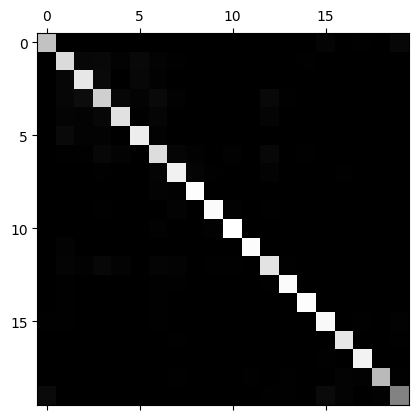

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

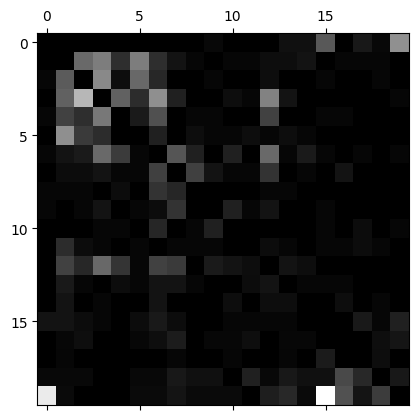

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
label_encoder.classes_

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

## Shortcuts in sklearn - pipelines
Sklearn allows us to build convenient `Pipelines`, which facilitate the management of our data and the training of our models enourmously. Consider for example:

In [ ]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb_clf', MultinomialNB())
])

We could even replace the two first lines of the pipeline by using `TfidfVectorizer`, which first fits and transforms the input the same way as the `CountVectorizer`.

In [ ]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('nb_clf', MultinomialNB())])

In [ ]:
scores = cross_val_score(text_clf, X_train, y_train, scoring='accuracy', cv=10)

In [ ]:
scores

array([0.84275618, 0.84540636, 0.86042403, 0.84893993, 0.85853227,
       0.8443855 , 0.85145889, 0.85411141, 0.85234306, 0.85411141])

## Model selection - find your best model
For every model you would like to train, there is a plethora of parameters you could set. How to find the best model? Again, sklearn has a solution: `GridSearchCV`. With grid search cross validation, you can set your hyperparameter space and train different models with all the parameter combinations. Keep in mind that depending on how many folds you train, the whole training procedure takes significantly longer. But let's set up grid search cross validation. We set up a new pipeline for a SVC

In [ ]:
from sklearn.model_selection import GridSearchCV

text_svc = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svc', LinearSVC())
])

param_grid = {'vect__ngram_range': [(1, 1), (1, 2)],
             'svc__loss': ['hinge', 'squared_hinge'],
             'svc__multi_class': ['ovr', 'crammer_singer']}

gs_svc = GridSearchCV(text_svc, param_grid, cv=5, n_jobs=4, verbose=1)
gs_svc.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


from sklearn.model_selection import GridSearchCV

text_svc = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svc', LinearSVC())
])

param_grid = {'vect__ngram_range': [(1, 1), (1, 2)],
             'svc__loss': ['hinge', 'squared_hinge'],
             'svc__multi_class': ['ovr', 'crammer_singer']}

gs_svc = GridSearchCV(text_svc, param_grid, cv=10, n_jobs=3, verbose=1, return_train_score=True)
gs_svc.fit(X_train, y_train)

In [ ]:
svc_df = pd.DataFrame.from_dict(gs_svc.cv_results_)
svc_df.sort_values(by=["rank_test_score"])

In [ ]:
gs_svc.predict(X_test)

In [ ]:
y_test

In [ ]:
best_model = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('svc', LinearSVC(loss='hinge', multi_class='crammer_singer'))
])

best_model.fit(X_train, y_train)

In [ ]:
best_model.predict(X_test)

In [ ]:
correct = 0

for index, prediction in enumerate(best_model.predict(X_test)):
    if prediction == y_test[index]:
        correct +=1

print('Accuracy: ', correct/y_test.shape[0])

##  Modern Solutions Sneak Peek - Transformer

Let's look at another task, paraphrase detection. Do two sentences have the same meaning?

In [ ]:
!pip install transformers datasets -qU

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
import torch

# 1. Load Pre-trained Model and Tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "AMHR/adversarial-paraphrasing-detector"  # Replace with the model you want to use
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 2. Prepare the Dataset
dataset = load_dataset("glue", "mrpc")
eval_dataset = dataset["validation"]

correct = 0
total = 0

# 3. Evaluate the Model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for i, example in enumerate(eval_dataset):
        if i > 5:
           break
        # Tokenize the inputs and get the model's predictions
        inputs = tokenizer(example['sentence1'], example['sentence2'], return_tensors='pt', truncation=True, padding=True, max_length=128)
        # Move input tensors to the same device as the model
        inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        # Print first 5 example pairs along with predictions and ground truth labels
        if i < 5:
            print(f"Example {i+1}")
            print(f"Sentence 1: {example['sentence1']}")
            print(f"Sentence 2: {example['sentence2']}")
            print(f"Prediction: {'Paraphrase' if predictions == 1 else 'Not a Paraphrase'}")
            print(f"Ground Truth: {'Paraphrase' if example['label'] == 1 else 'Not a Paraphrase'}")
            print("="*50)


In [ ]:
def predict_paraphrase(sentence1, sentence2, model, tokenizer, device):
    # Prepare the sentences for the model
    inputs = tokenizer(sentence1, sentence2, return_tensors='pt', truncation=True, padding=True, max_length=128)

    # Move the input tensors to the device the model is on
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

    model.eval()
    with torch.no_grad():
        # Get model's prediction
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    return "Paraphrase" if prediction == 1 else "Not a Paraphrase"

In [ ]:
# Custom Sentences testing
sentence1 = "This tutorial rocks."
sentence2 = "I want to throw rocks at this Tutor."

result = predict_paraphrase(sentence1, sentence2, model, tokenizer, device)
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")
print(f"Prediction: {result}")

In [ ]:
# Custom Sentences Testing
sentence1 = "I am so tired but I want to stay in this tutorial."
sentence2 = "I am exhausted and forced to be here."

result = predict_paraphrase(sentence1, sentence2, model, tokenizer, device)
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")
print(f"Prediction: {result}")

In [ ]:
# Custom Sentences Testing
sentence1 = "This field of research is pretty cool."
sentence2 = "I find this line of research very cool."

result = predict_paraphrase(sentence1, sentence2, model, tokenizer, device)
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")
print(f"Prediction: {result}")